### Sequential encoding stability: 
- Load significant units
- load ANOVA results for conf and pref from train-half of trials, 
- compare to test half:
    - examine ordering, 
    - examine peak times correlation

In [13]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools
from matplotlib.colors import LogNorm, Normalize


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# var_name= "BeliefConf"
# var = "x_BeliefConf_comb_time_fracvar"
var_name= "BeliefPref"
var = "x_BeliefPref_comb_time_fracvar"
agg_mode = "max"
subject = "SA"
region_level = "structure_level2"
sig_region_thresh = 20


### Find significant units

#### Can use units that are at some time point 99th significant for either variable

In [83]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = subject
_, _, pref_res = io_utils.read_anova_res_all_time(args, "99th", "BeliefPref", read_shuffle=True)
pref_sig_units = pref_res[["feat", "PseudoUnitID", region_level]]

_, _, conf_res = io_utils.read_anova_res_all_time(args, "99th", "BeliefConf", read_shuffle=True)
conf_sig_units = conf_res[["feat", "PseudoUnitID", region_level]]

sig_units = pd.merge(pref_sig_units, conf_sig_units, on=["feat", "PseudoUnitID", region_level])
# sig_units = sig_units[sig_units.structure_level2.isin(["lateral_prefrontal_cortex (lat_PFC)"])]

num_units_by_region = sig_units.groupby(region_level).PseudoUnitID.nunique().reset_index(name="num_units")
sig_regions = num_units_by_region[num_units_by_region.num_units > sig_region_thresh][region_level]

sig_units = sig_units[sig_units[region_level].isin(sig_regions)][["feat", "PseudoUnitID"]]



#### Or can use all units

In [84]:
# args = argparse.Namespace(
#     **AnovaConfigs()._asdict()
# )
# args.conditions = ["BeliefConf", "BeliefPartition"]
# args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
# args.window_size = 500
# args.subject = subject
# _, _, all_res = io_utils.read_anova_res_all_time(args, "all", "", read_shuffle=False)
# num_units_by_region = all_res.groupby(region_level).PseudoUnitID.nunique().reset_index(name="num_units")
# sig_regions = num_units_by_region[num_units_by_region.num_units > sig_region_thresh][region_level]
# sig_units = all_res[all_res[region_level].isin(sig_regions)][["feat", "PseudoUnitID"]]

#### Or can look at units where belief partition was signficant in either StimOnset or FBOnset intervals:

In [85]:
# sig_units_path = f"/data/patrick_res/firing_rates/{subject}/StimOnset_belief_partition_all_time_95th_units.pickle"
# sig_units = pd.read_pickle(sig_units_path)


In [86]:
sig_units

,feat,PseudoUnitID
58,CIRCLE,2018070908
59,CIRCLE,2018070908
60,CIRCLE,2018070908
61,CIRCLE,2018070908
62,CIRCLE,2018070908
...,...,...
21371,SWIRL,2018090615
21372,SWIRL,2018090615
21373,SWIRL,2018090615
21374,SWIRL,2018090615


In [87]:
sig_units.groupby("feat").PseudoUnitID.nunique()

feat
CIRCLE      25
CYAN        17
ESCHER      17
GREEN        9
MAGENTA     21
POLKADOT    16
RIPPLE      14
SQUARE      25
STAR        17
SWIRL        8
TRIANGLE    20
YELLOW      26
Name: PseudoUnitID, dtype: int64

### Load for one half, test on the other

In [88]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = subject
args.split_idx = 0
# res = io_utils.read_anova_good_units(args, "all", "", read_shuffle=False)
stim_res, fb_res, all_res = io_utils.read_anova_res_all_time(args, "all", "", read_shuffle=False)
all_res = all_res.fillna(0)
all_res = pd.merge(all_res, sig_units, on=["PseudoUnitID", "feat"])
# res = res[res.structure_level2]
# res = res[res.PseudoUnitID.isin(units)]

if agg_mode == "mean":
    res = all_res.groupby(["PseudoUnitID", region_level, "trial_event", "abs_time"]).mean(numeric_only=True).reset_index()
elif agg_mode == "max":
    res = all_res.groupby(["PseudoUnitID", region_level, "trial_event", "abs_time"]).max(numeric_only=True).reset_index()



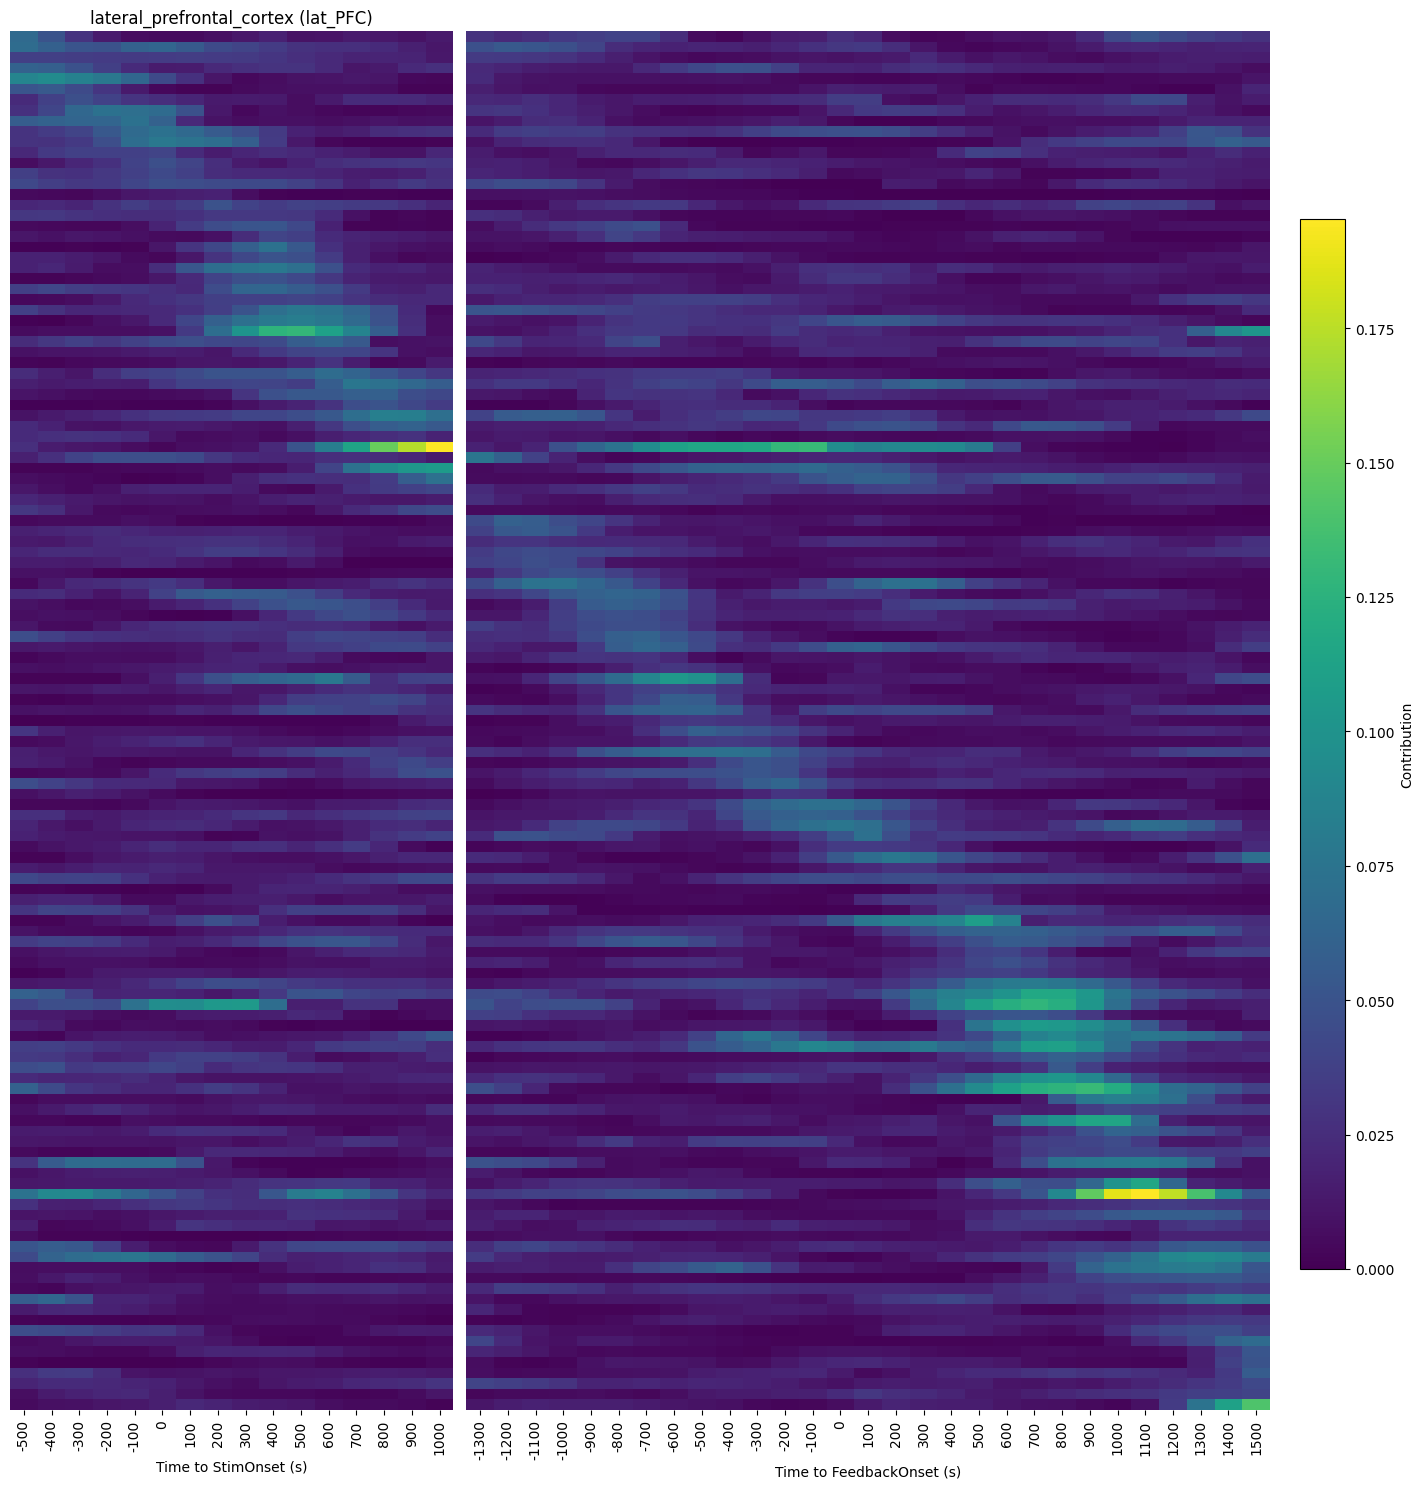

In [89]:
train_peaks, train_order = spike_utils.find_peaks(res, value_col=var, time_col="abs_time", region_level=region_level)
_, _ = visualization_utils.plot_pop_heatmap_by_time(stim_res, fb_res, res, value_col=var, time_col="WindowEndMilli", orders=train_order, region_level=region_level)

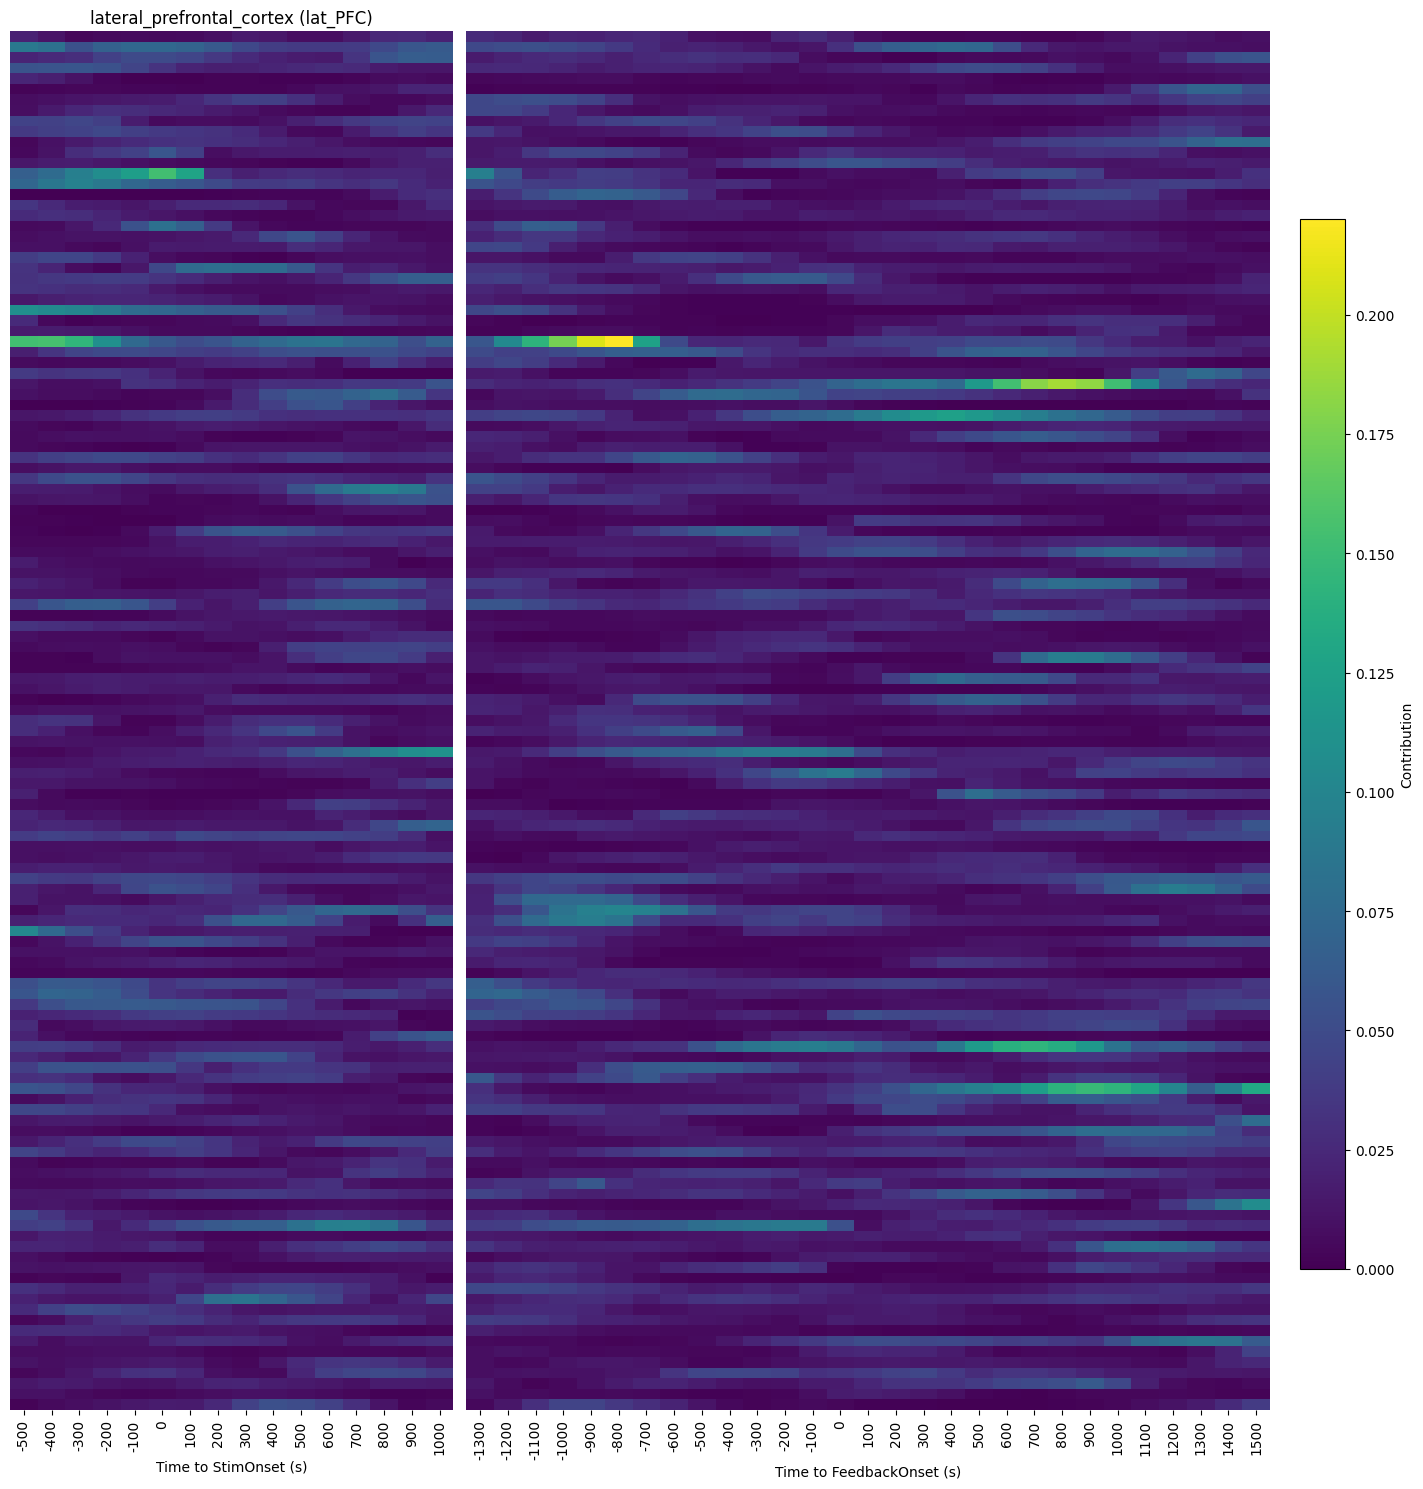

In [90]:
args.split_idx = 1
stim_res, fb_res, all_res = io_utils.read_anova_res_all_time(args, "all", "", read_shuffle=False)
all_res = all_res.fillna(0)
all_res = pd.merge(all_res, sig_units, on=["PseudoUnitID", "feat"])

if agg_mode == "mean":
    res = all_res.groupby(["PseudoUnitID", region_level, "trial_event", "abs_time"]).mean(numeric_only=True).reset_index()
elif agg_mode == "max":
    res = all_res.groupby(["PseudoUnitID", region_level, "trial_event", "abs_time"]).max(numeric_only=True).reset_index()

test_peaks, _ = spike_utils.find_peaks(res, value_col=var, time_col="abs_time", region_level=region_level)

_, _ = visualization_utils.plot_pop_heatmap_by_time(stim_res, fb_res, res, value_col=var, time_col="WindowEndMilli", region_level=region_level, orders=train_order)

In [91]:
test_peaks = pd.concat(test_peaks.values())
train_peaks = pd.concat(train_peaks.values())
peaks = pd.merge(test_peaks, train_peaks, on="PseudoUnitID", suffixes=("_test", "_train"))

In [92]:
peaks

,PseudoUnitID,peak_time_test,peak_time_train
0,2018061504,2800,1700
1,2018061515,1400,2800
2,2018062220,3600,3800
3,2018062525,3100,1300
4,2018070508,3700,0
...,...,...,...
126,2018100907,1500,1900
127,2018100908,800,3400
128,2018101007,800,800
129,20180725000124,-500,-400


Text(0.5, 1.0, 'r: 0.19643255790941447, p: 0.024532814889617657')

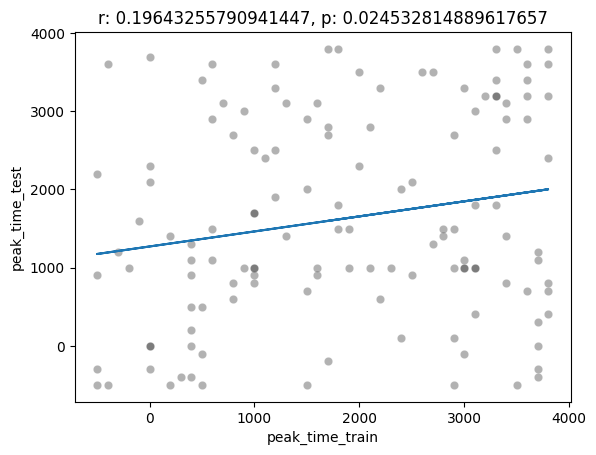

In [93]:
fig, ax = plt.subplots()
slope, intercept, r_value, p_value, std_err = visualization_utils.sns_plot_correlation(peaks, "peak_time_train", "peak_time_test", ax)
ax.set_title(f"r: {r_value}, p: {p_value}")

### Cross variable ordering:

In [116]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = subject
stim_res, fb_res, all_res = io_utils.read_anova_res_all_time(args, "all", "", read_shuffle=False)
all_res = all_res.fillna(0)
all_res = pd.merge(all_res, sig_units, on=["PseudoUnitID", "feat"])

if agg_mode == "mean":
    res = all_res.groupby(["PseudoUnitID", region_level, "trial_event", "abs_time"]).mean(numeric_only=True).reset_index()
elif agg_mode == "max":
    res = all_res.groupby(["PseudoUnitID", region_level, "trial_event", "abs_time"]).max(numeric_only=True).reset_index()



In [117]:
pref_peaks, pref_order = spike_utils.find_peaks(res, value_col="x_BeliefPref_comb_time_fracvar", time_col="abs_time", region_level=region_level)
conf_peaks, conf_order = spike_utils.find_peaks(res, value_col="x_BeliefConf_comb_time_fracvar", time_col="abs_time", region_level=region_level)

({'all_regions': 93    2019090402
  44    2019053007
  68    2019071004
  11    2019021513
  28    2019022800
           ...    
  53    2019060603
  63    2019070208
  3     2019020701
  41    2019052914
  54    2019060606
  Name: PseudoUnitID, Length: 97, dtype: int64},
 {'all_regions': 93    2019090402
  44    2019053007
  68    2019071004
  11    2019021513
  28    2019022800
           ...    
  53    2019060603
  63    2019070208
  3     2019020701
  41    2019052914
  54    2019060606
  Name: PseudoUnitID, Length: 97, dtype: int64},
 (<Figure size 1500x1500 with 3 Axes>,
  array([[<Axes: title={'center': 'all_regions'}, xlabel='Time to StimOnset (s)'>,
          <Axes: xlabel='Time to FeedbackOnset (s)'>]], dtype=object)))

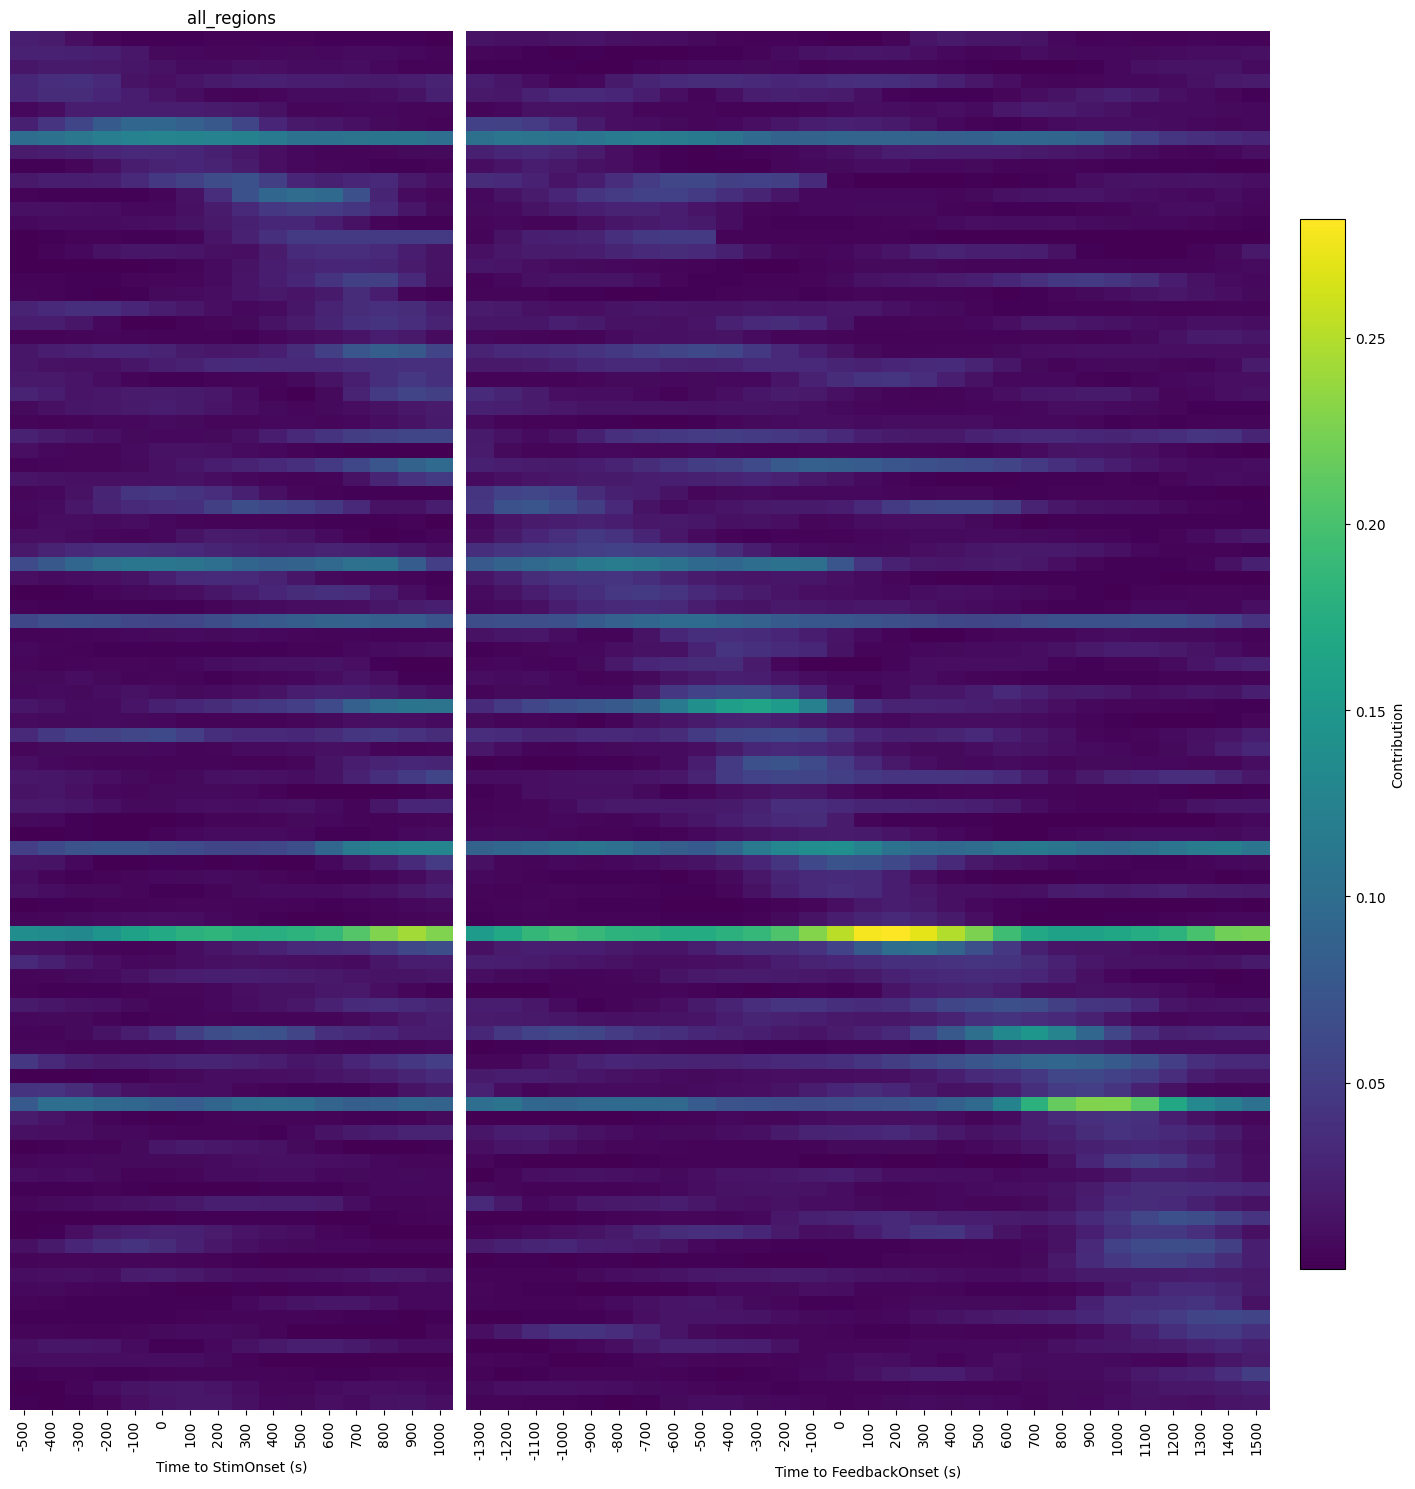

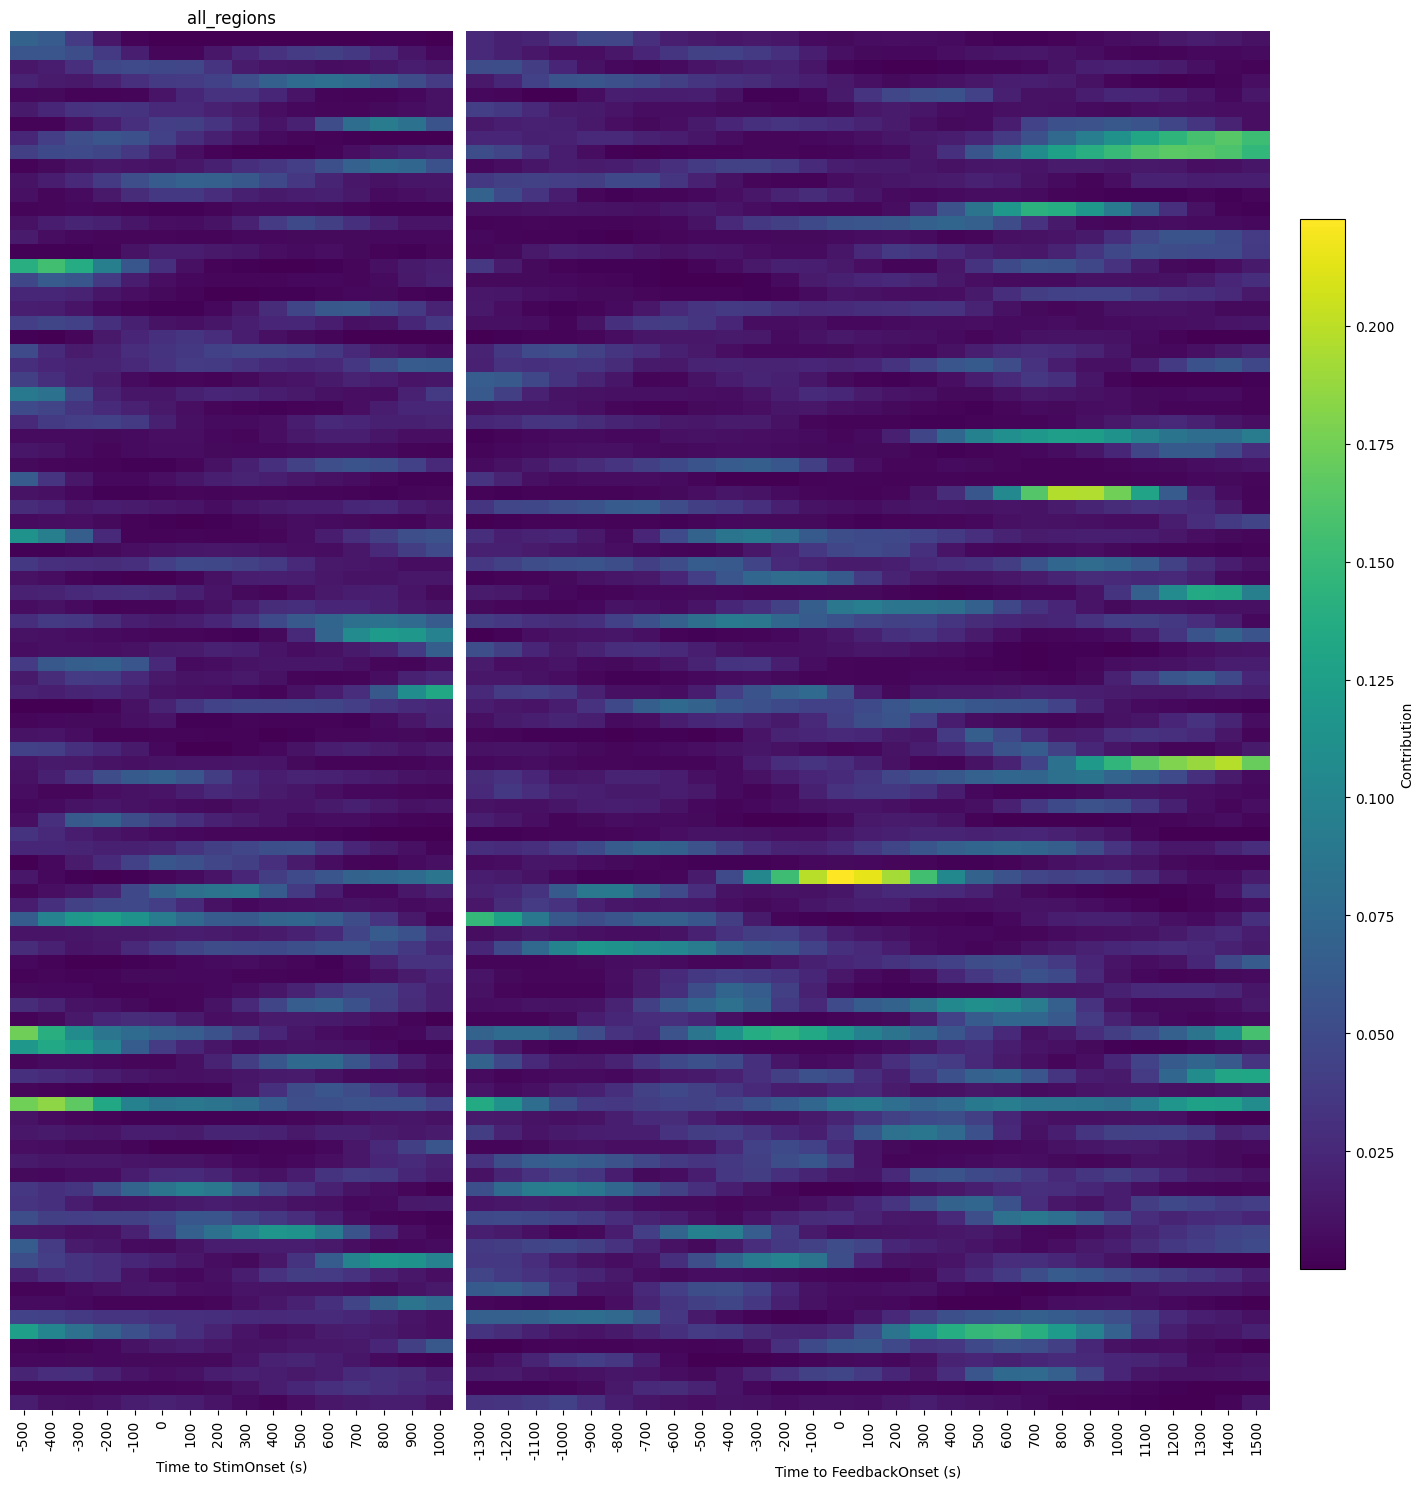

In [118]:
_, _, visualization_utils.plot_pop_heatmap_by_time(stim_res, fb_res, res, value_col="x_BeliefPref_comb_time_fracvar", time_col="WindowEndMilli", region_level=region_level, orders=pref_order)
_, _, visualization_utils.plot_pop_heatmap_by_time(stim_res, fb_res, res, value_col="x_BeliefConf_comb_time_fracvar", time_col="WindowEndMilli", region_level=region_level, orders=pref_order)


Text(0.5, 1.0, 'r: 0.07748875347321028, p: 0.45059855757171263')

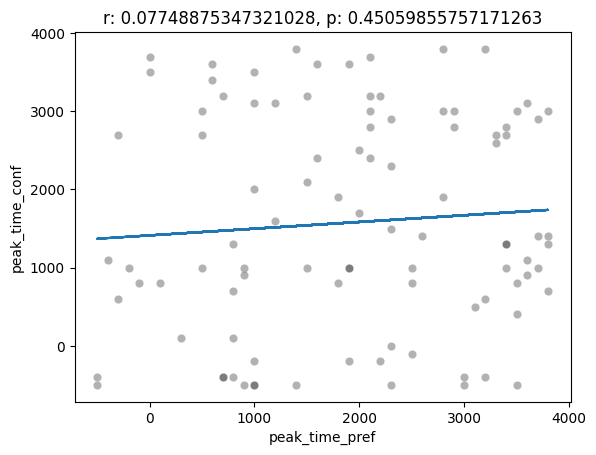

In [115]:
pref_peaks = pd.concat(pref_peaks.values())
conf_peaks = pd.concat(conf_peaks.values())
peaks = pd.merge(pref_peaks, conf_peaks, on="PseudoUnitID", suffixes=("_pref", "_conf"))

fig, ax = plt.subplots()
slope, intercept, r_value, p_value, std_err = visualization_utils.sns_plot_correlation(peaks, "peak_time_pref", "peak_time_conf", ax)
ax.set_title(f"r: {r_value}, p: {p_value}")